# Network Design Covid

In [1]:
import networkx
import pandas
import numpy as np
import matplotlib.pyplot as plt
import time
import ndex2
import json
import random

Clean network and join integrated interactome to the COVID disease interactome

In [2]:
drugs = pandas.read_csv('inputs/Top200Drugs.csv', index_col='Unnamed: 0')
drugs = drugs.drop_duplicates(['pert_iname', 'target'])

print(drugs.shape)
drugs.head()

(109, 12)


,Unnamed: 0.1,CellLine,DrugStatus,DrugType,Slope,broad_id,pert_iname,clinical_phase,moa,target,disease_area,indication
0,CPC003_HCC515_24H:BRD-K22503835-001-06-0:10,HCC515,Drug,HDAC inhibitor,-0.889451,BRD-K22503835,scriptaid,Preclinical,HDAC inhibitor,HDAC1|HDAC2|HDAC3|HDAC4|HDAC5|HDAC6|HDAC7|HDAC...,NaN,NaN
6,CPC001_HCC515_24H:BRD-K62289640-003-01-9:10,HCC515,Drug,Cannabinoid receptor agonist,-0.859181,BRD-K62289640,lylamine,Preclinical,cannabinoid receptor agonist,CNR1,NaN,NaN
7,CPC002_HCC515_24H:BRD-A28970875-300-03-1:10,HCC515,Drug,Protein synthesis inhibitor,-0.779664,BRD-A28970875,puromycin,Preclinical,protein synthesis inhibitor,NHP2L1|RPL10L|RPL11|RPL13A|RPL15|RPL19|RPL23|R...,NaN,NaN
9,CPC004_HCC515_24H:BRD-K43389675-001-01-3:10,HCC515,Drug,RNA synthesis inhibitor,-0.777525,BRD-K43389675,daunorubicin,Launched,RNA synthesis inhibitor|topoisomerase inhibitor,TOP2A|TOP2B,hematologic malignancy,acute myeloid leukemia (AML)|acute lymphoblast...
21,CPC006_A549_6H:BRD-K04853698-003-01-4:10,A549,Drug,Serine/threonine kinase inhibitor,-0.745074,BRD-K04853698,LDN193189,Preclinical,bone morphogenic protein inhibitor,ACVR1|BMPR1A,NaN,NaN


In [3]:
genes = pandas.read_csv('inputs/CovidICU_vs_nonCovidICU.csv').sort_values('logFC', ascending=False)

print(genes.shape)
genes.head()

(747, 9)


,Unnamed: 0,SYMBOL,ENTREZID,logFC,AveExpr,t,P.Value,adj.P.Val,B
333,IGHG1,IGHG1,3500,4.964008,8.071127,6.875179,2.922480e-10,2.564954e-07,12.983867
590,SDC1,SDC1,6382,4.129016,-0.775642,4.609049,1.012460e-05,3.875719e-04,3.225447
197,DEFA1,DEFA1,1667,3.887993,6.293610,4.665478,8.032272e-06,3.285950e-04,3.082292
362,JCHAIN,JCHAIN,3512,3.830713,7.880533,6.837700,3.529267e-10,2.564954e-07,12.783528
715,UCHL1,UCHL1,7345,3.733588,-1.218837,5.977002,2.368695e-08,3.752365e-06,8.692190


In [4]:
#Full covid and human merged interactome
inter = pandas.read_csv('outputs/COVID_human_interactome.csv', index_col='Unnamed: 0')
inter.head()

,geneID_A,geneID_B,Type
0,PHYHIP,KIF15,Human
1,EGR1,KIF15,Human
2,E2F4,KIF15,Human
3,CHD3,KIF15,Human
4,YY1,KIF15,Human


In [5]:
viral = inter[inter['Type'] == 'Viral']
hum = inter[inter['Type'] == 'Human']
print(viral.shape, hum.shape, inter.shape)

(331, 3) (323858, 3) (324189, 3)


In [6]:
#Reading interactome into a networkx graph
net = networkx.from_pandas_edgelist(inter, 'geneID_A', "geneID_B")

In [7]:
print(len(net.edges), len(net.nodes))

323919 17975


# Diffusion Theory

Define diffusion model/methods

0.0
1


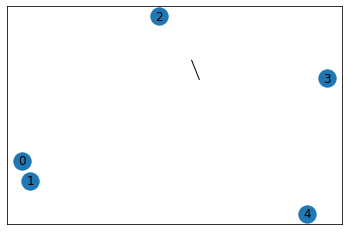

In [8]:
#t1 = time.time()
#gAdj = networkx.complete_graph(4000)
#print(time.time() - t1)
t1 = time.time()
gAdj = networkx.fast_gnp_random_graph(5, 0.3)
print(time.time() - t1)
print(len(gAdj.edges))
networkx.draw_networkx(gAdj)

In [9]:
gMat = networkx.to_pandas_adjacency(gAdj)
gMat

,0,1,2,3,4
0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0


In [10]:
#Convert to numpy matrix
adjMat = gMat.to_numpy()
#Normalize for column sum
adjMat = adjMat / adjMat.sum(axis=0)
adjMat

<ipython-input-10-2cf9c17063f1>:4: RuntimeWarning: invalid value encountered in true_divide
  adjMat = adjMat / adjMat.sum(axis=0)


array([[ 0.,  1., nan, nan, nan],
       [ 1.,  0., nan, nan, nan],
       [ 0.,  0., nan, nan, nan],
       [ 0.,  0., nan, nan, nan],
       [ 0.,  0., nan, nan, nan]])

In [11]:
#Generate diffusion seed vector
seeds = [2, 4]
vec = np.array([[int(k)] for k in gMat.index.isin(seeds)])
print(vec)

[[0]
 [0]
 [1]
 [0]
 [1]]


In [12]:
def diffuseBase(net, seed, cand):
    adj = normAdj(net)
    nomMat = networkx.to_pandas_adjacency(net)
    sv = seedVec(nomMat, seed)
    res = diffuse(adj, sv)[0]
    return pandas.Series((k[0] for k in res), nomMat.index)

def diffuse(adj, seedV, alpha=0.3):
    currVec = seedV
    k = 0
    normVals = []
    temp = 10
    while temp >= -6.5:
        prevVec = currVec
        currVec = (1-alpha)*np.matmul(adj, currVec) 
        currVec += alpha * seedV
        #Uncomment to see step by step diffusion
        #print(currVec)
        #print('L1 value %s :'%k, L1norm(currVec - prevVec))
        normVals.append(max(np.log10(L1norm(currVec - prevVec))))
        temp = normVals[-1]
        k += 1
    prevVec = currVec
    currVec = (1-alpha)*np.matmul(adj, currVec) + alpha * seedV
    normVals.append(max(np.log10(L1norm(currVec - prevVec))))
    temp = normVals[-1]
    k += 1
    return currVec, normVals

def L1norm(vec):
    return np.absolute(vec).sum(axis=0)

def seedVec(mat, edgeList, norm=False):
    return np.array([[int(k)] for k in mat.index.isin(edgeList)])

def normAdj(net, norm='column'):
    mat = networkx.to_pandas_adjacency(net)
    mat = mat.to_numpy()
    #Normalize for column sum
    mat = mat / mat.sum(axis=0)
    return mat

#Sampling function
#Inputs: seed degree to seed nodes map, seed degree to all nodes map, samples desired
#Outputs: Randomly sampled seed matrix

In [13]:
#Model 2: Candidate-based adjustment pseudocode
def candAdj(net, seed, cand, goi = 60):
    #Convert Network to Adjacency Matrix
    mat = normAdj(net)
    #Run and store diffusion result for starter seed
    nomMat = networkx.to_pandas_adjacency(net)
    sv = seedVec(nomMat, seed)
    diffBase = diffuse(mat, sv)[0] #Raw diffusion vector array
    diffLab = pandas.Series((k[0] for k in diffBase), nomMat.index) # Labeled frame
    #Map candidate nodes to degree
    candMap = dict(net.degree(cand))
    #Map all nodes to list of degrees
    netMap = dict(net.degree())
    #Flip the dict to map the degree values to a list of associated nodes
    flip = {}
    for k in netMap:
        temp = flip.get(netMap[k], [])
        temp.append(k)
        flip[netMap[k]] = temp
    #Loop for each cand gene with selected number of genes of interest
    z = {}
    for c in cand:
        #find genes of a similar degree to a candidate gene of interest until list of similar genes crosses threshold
        comp = []
        k = 0
        comp += flip[candMap[c]]
        while len(comp) < goi:
            k += 1
            comp += flip.get(candMap[c] + k, []) + flip.get(candMap[c] - k, [])
        comp = comp[:goi]
        #Calculate mean probability of similar genes
        probSub = np.array([diffLab[k] for k in comp])
        mean = np.average(probSub)
        #Calculate st dev of similar genes
        st = np.std(probSub)
        #Calculate zscore for gene of interest
        zval = (diffLab[c] - mean)/st
        #Append
        z[c] = zval
    #Return list of z-scores
    z = pandas.Series(z).sort_values(ascending=False)
    print(z.head())
    return z

In [14]:
#Model 3: Eigenvector centrality adjustment pseudocode
def eigenAdj(net, seed, cand):
    #Convert Network to Adjacency Matrix
    mat = normAdj(net)
    #Run and store diffusion result for starter seed
    nomMat = networkx.to_pandas_adjacency(net)
    sv = seedVec(nomMat, seed)
    #print(mat, sv)
    diffBase = diffuse(mat, sv)[0] #Raw diffusion vector array
    diffLab = pandas.Series((k[0] for k in diffBase), nomMat.index) # Labeled frame
    #Run and store diffusion result for starter seed with alpha=0
    fr_diffBase = diffuse(mat, sv, alpha=0)[0] #Raw diffusion vector array
    fr_diffLab = pandas.Series((k[0] for k in fr_diffBase), nomMat.index) # Labeled frame
    #Divide standard by alpha = 0 and log-scale
    quo = np.log(diffBase/(fr_diffBase + 0.000000000000001))
    quo = pandas.Series((k[0] for k in quo), nomMat.index)
    quo = quo.sort_values(ascending=False)
    #Return matrix
    return quo

In [15]:
#Adjustment Model 3: High-Low Global Split
#Input: network, seed, candidate, reference model function
#Output: Optimized prioritization order
def avgSeedDegChooser(net, seed, cand, func=eigenAdj, stratify=True):
    #Calculate cutoff degree (average degree of whole network)
    degs = [k[1] for k in net.degree]
    cutoff = sum(degs)/len(degs)
    print('Average Overall Degree:', cutoff)
    #Calculate average degree of seed genes
    seedDegs = [k[1] for k in net.degree(seed)]
    seedAvg = sum(seedDegs)/len(seedDegs)
    print('Average Seed Degree:', seedAvg)
    #If seed is higher than cutoff, return raw
    #If seed <= cutoff, return adjusted
    if seedAvg > cutoff and stratify:
        vec = diffuseBase(net, seed, cand)
    else:
        vec = func(net, seed, cand)
    vec = vec.sort_values(ascending=False)
    return vec

In [16]:
steady, l1dist = diffuse(adjMat, vec)
print(steady)
print(l1dist)

[[nan]
 [nan]
 [nan]
 [nan]
 [nan]]
[nan, nan]


In [17]:
print(gAdj.nodes)
print(seeds)
print(set(gAdj.nodes) - set(seeds))

[0, 1, 2, 3, 4]
[2, 4]
{0, 1, 3}


In [18]:
#avgSeedDegChooser(gAdj, seeds, set(gAdj.nodes) - set(seeds))

Diffuse the COVID proteins in integrated network

In [19]:
#Generating covid/human interactome adjacency matrix
covAdj = networkx.to_pandas_adjacency(net)
print(covAdj.shape)
#covAdj.head()

(17975, 17975)


In [20]:
seeds = [k for k in covAdj.index if k[:9] == 'sars-cov2']
vec = np.array([[int(k)] for k in covAdj.index.isin(seeds)])
print(vec.sum(axis=0))
print(seeds)

[27]
['sars-cov2m', 'sars-cov2nsp7', 'sars-cov2n', 'sars-cov2nsp9', 'sars-cov2orf9b', 'sars-cov2nsp13', 'sars-cov2orf9c', 'sars-cov2nsp1', 'sars-cov2nsp12', 'sars-cov2e', 'sars-cov2nsp8', 'sars-cov2orf8', 'sars-cov2nsp14', 'sars-cov2nsp4', 'sars-cov2nsp11', 'sars-cov2nsp5', 'sars-cov2orf6', 'sars-cov2orf10', 'sars-cov2nsp6', 'sars-cov2orf7a', 'sars-cov2nsp2', 'sars-cov2nsp5_c145a', 'sars-cov2orf3a', 'sars-cov2nsp15', 'sars-cov2nsp10', 'sars-cov2orf3b', 'sars-cov2spike']


In [21]:
disMod = avgSeedDegChooser(net, seeds, set(net.nodes) - set(seeds))
disMod.head()

Average Overall Degree: 36.04105702364395
Average Seed Degree: 12.25925925925926


<ipython-input-14-c602dc0ef44d>:15: RuntimeWarning: divide by zero encountered in log
  quo = np.log(diffBase/(fr_diffBase + 0.000000000000001))


sars-cov2nsp11         8.911189
sars-cov2orf3b         8.883926
sars-cov2nsp5          8.874083
sars-cov2nsp5_c145a    8.215565
sars-cov2spike         8.204807
dtype: float64

In [22]:
disMod.head(30)

sars-cov2nsp11         8.911189
sars-cov2orf3b         8.883926
sars-cov2nsp5          8.874083
sars-cov2nsp5_c145a    8.215565
sars-cov2spike         8.204807
sars-cov2orf7a         8.193162
sars-cov2nsp14         7.812865
sars-cov2orf6          7.785867
sars-cov2nsp15         7.781360
sars-cov2nsp6          7.525281
sars-cov2nsp10         7.279542
sars-cov2e             7.107117
sars-cov2nsp1          7.098905
sars-cov2nsp2          6.942471
sars-cov2nsp4          6.820051
sars-cov2orf3a         6.813152
sars-cov2orf10         6.691450
sars-cov2orf9b         6.510098
sars-cov2n             6.173707
sars-cov2nsp9          6.114976
TBCA                   5.992940
sars-cov2nsp12         5.958028
GPX1                   5.745988
sars-cov2nsp8          5.713329
sars-cov2orf9c         5.637301
GLA                    5.618432
sars-cov2m             5.502648
DPH5                   5.461500
sars-cov2nsp7          5.424806
SIGMAR1                5.207244
dtype: float64

In [23]:
c2 = disMod

In [24]:
nest = c2[c2.index.isin(seeds)]
nest.head()

sars-cov2nsp11         8.911189
sars-cov2orf3b         8.883926
sars-cov2nsp5          8.874083
sars-cov2nsp5_c145a    8.215565
sars-cov2spike         8.204807
dtype: float64

In [25]:
c3 = c2.sort_values(ascending=False)
c3.head(50)

sars-cov2nsp11         8.911189
sars-cov2orf3b         8.883926
sars-cov2nsp5          8.874083
sars-cov2nsp5_c145a    8.215565
sars-cov2spike         8.204807
sars-cov2orf7a         8.193162
sars-cov2nsp14         7.812865
sars-cov2orf6          7.785867
sars-cov2nsp15         7.781360
sars-cov2nsp6          7.525281
sars-cov2nsp10         7.279542
sars-cov2e             7.107117
sars-cov2nsp1          7.098905
sars-cov2nsp2          6.942471
sars-cov2nsp4          6.820051
sars-cov2orf3a         6.813152
sars-cov2orf10         6.691450
sars-cov2orf9b         6.510098
sars-cov2n             6.173707
sars-cov2nsp9          6.114976
TBCA                   5.992940
sars-cov2nsp12         5.958028
GPX1                   5.745988
sars-cov2nsp8          5.713329
sars-cov2orf9c         5.637301
GLA                    5.618432
sars-cov2m             5.502648
DPH5                   5.461500
sars-cov2nsp7          5.424806
SIGMAR1                5.207244
sars-cov2nsp13         5.203348
SLC44A2 

In [26]:
#Building the disease module
prio = list(c3.index)
print(len(prio), prio[:5])
print(len(net.nodes))
modList =[]
lccSize = []
seedcount = []
for k in range(376):
    modList.append(prio[k])
    sub = net.subgraph(modList)
    lcc = max(networkx.connected_components(sub), key=len)
    lccSize.append(len(lcc))
    seedcount.append(len(set(seeds).intersection(set(lcc))))
print(set(lccSize), set(seedcount))

17975 ['sars-cov2nsp11', 'sars-cov2orf3b', 'sars-cov2nsp5', 'sars-cov2nsp5_c145a', 'sars-cov2spike']
17975
{1, 2, 3, 4, 5, 9, 10, 12, 13, 17, 18, 19, 20, 21, 31, 32, 33, 34, 35, 53, 63, 64, 79, 92, 93, 94, 95, 96, 119, 120, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 170, 171, 172, 195, 196, 197, 198, 199, 200, 201, 202, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 376} {1, 2, 3, 5, 8, 9, 10, 11, 14, 16, 17, 20, 23, 24, 

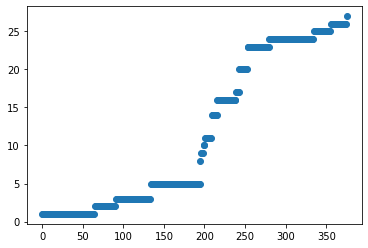

In [27]:
plt.scatter(list(range(len(seedcount))), seedcount)
plt.show()

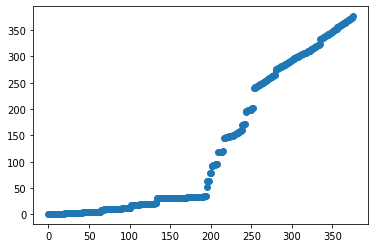

In [28]:
plt.scatter(list(range(len(lccSize))), lccSize)
plt.show()

In [29]:
disMod = net.subgraph(modList)
print(len(modList))

376


In [30]:
for n in disMod.nodes:
    node = disMod.nodes[n]
    node['degree'] = dict(disMod.degree)[n]
    if n[:8] == 'sars-cov':
        node['type'] = 'CoV'
    else:
        node['type'] = 'Human'

In [31]:
modFile = ndex2.create_nice_cx_from_networkx(disMod).to_cx()
with open('covidLCC.cx', 'w') as f:
    json.dump(modFile, f)

Generating CX


# Drug Analysis for the Disease Module

In [32]:
#Establish List of Disease Module Genes
print(len(modList))
nGenes = set(genes['SYMBOL'])
nGenes = [k for k in nGenes if k in net.nodes]
print(len(nGenes))

376
682


In [33]:
#Establish list of drug targets
compounds = pandas.read_csv('LINCS_COVID_PUBLIC_drug_shortlist.csv')
dTars = set()
for k in compounds['target']:
    for drug in k.split('|'):
        dTars.add(drug)

dTars = dTars.intersection(set(net.nodes()))
print(len(dTars))#, dTars)
print(len(net.nodes))
print(len(dTars.intersection(set(net.nodes())))) #All targets are part of the provided interactome
#compounds.head()

458
17975
458


In [34]:
test = [k for k in net.nodes if 'sars-cov' not in k]
nCS = net.subgraph(test)
nCmod = [k for k in modList if 'sars-cov' not in k]
print(len(net.nodes), len(nCS.nodes))
#Use nCS for interactome without covid viral proteins

17975 17948


In [35]:
distanceGrid = {}
for k in dTars:
    distanceGrid[k] = {}
    for m in dTars:
        if networkx.has_path(net, k, m):
            distanceGrid[k][m] = len(networkx.shortest_path(net, k, m))
        else:
            distanceGrid[k][m] = 10

distFrame = pandas.DataFrame(distanceGrid)
print(distFrame.shape)
distFrame.head()

(458, 458)


,VCP,ALK,GRM8,CDK3,GLRA1,SLC25A18,VKORC1L1,GLS,MC4R,TNKS,...,MAOB,AKT3,HDAC9,MAP2K1,TAT,RXRB,EIF2AK4,HDAC6,PRKCD,FLT4
VCP,1,3,4,3,4,4,3,3,4,3,...,3,3,3,2,4,2,3,2,3,3
ALK,3,1,4,3,3,4,4,4,4,4,...,4,3,4,3,4,4,3,3,3,3
GRM8,4,4,1,4,5,5,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
CDK3,3,3,4,1,4,4,3,3,4,3,...,3,3,3,3,4,3,3,3,3,3
GLRA1,4,3,5,4,1,5,4,4,4,4,...,4,4,4,4,5,4,4,3,4,4


C:\Users\rahul\AppData\Roaming\Python\Python38\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


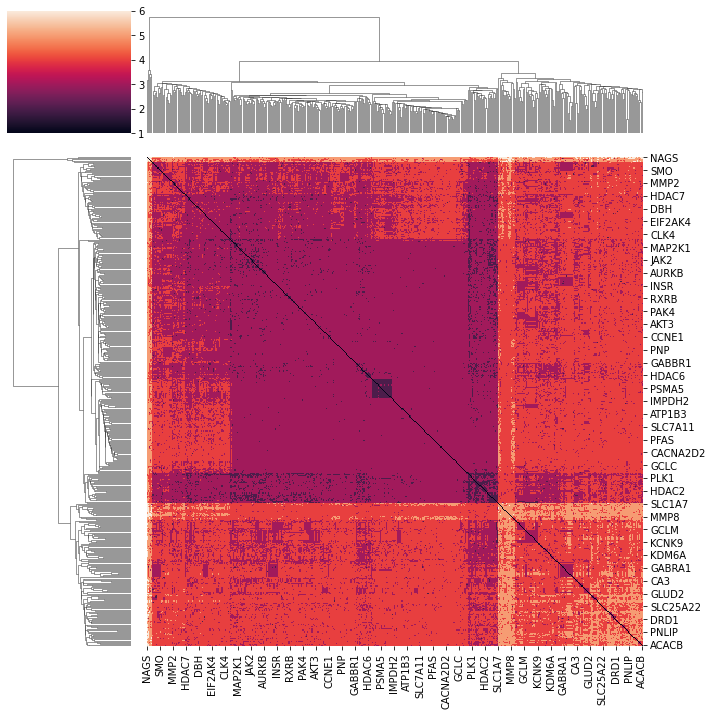

In [36]:
import seaborn

fig = seaborn.clustermap(distFrame, vmax=6)
plt.tight_layout()

In [37]:
#fig.savefig('DrugDrugDist.png')

In [38]:
distanceGrid = {}
for k in dTars:
    distanceGrid[k] = {}
    for m in nCmod:
        if networkx.has_path(net, k, m):
            distanceGrid[k][m] = len(networkx.shortest_path(net, k, m))
        else:
            distanceGrid[k][m] = 10

distFrame = pandas.DataFrame(distanceGrid)
print(distFrame.shape)
distFrame.head()

(349, 458)


,VCP,ALK,GRM8,CDK3,GLRA1,SLC25A18,VKORC1L1,GLS,MC4R,TNKS,...,MAOB,AKT3,HDAC9,MAP2K1,TAT,RXRB,EIF2AK4,HDAC6,PRKCD,FLT4
TBCA,3,4,4,3,4,5,3,3,4,3,...,3,3,3,3,4,2,4,3,3,3
GPX1,4,3,5,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,3,4
GLA,3,4,4,3,4,5,3,3,4,3,...,3,3,3,3,4,3,4,3,3,3
DPH5,3,4,4,3,4,5,3,3,4,3,...,3,3,4,3,4,3,4,3,3,3
SIGMAR1,3,4,4,3,4,5,3,3,4,3,...,3,3,4,3,4,3,4,3,3,3


C:\Users\rahul\AppData\Roaming\Python\Python38\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


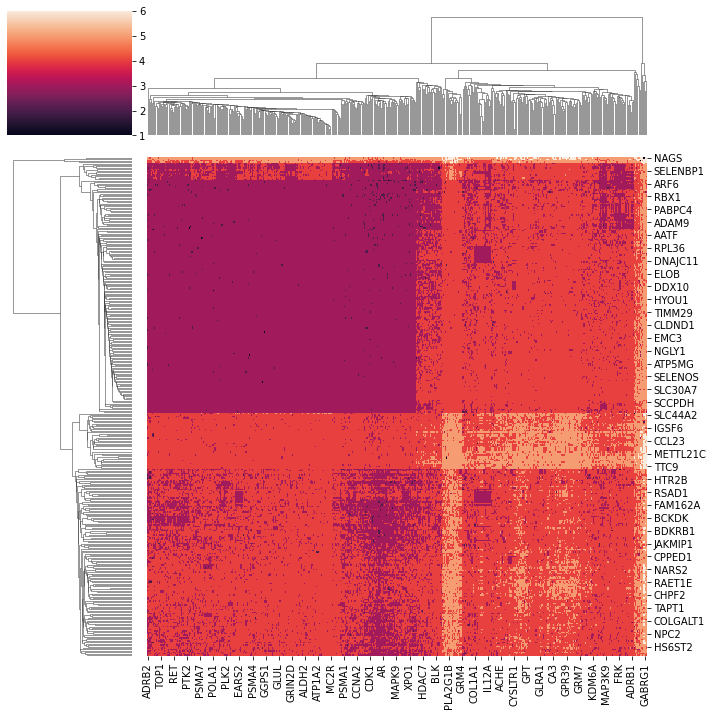

In [39]:
fig = seaborn.clustermap(distFrame, vmax=6)
plt.tight_layout()

In [40]:
#fig.savefig('DrugDisDist.png')

In [41]:
# Rerun after extracting high degree nodes
keyNodes = {}
for k in dTars:
    for m in nCmod:
        if networkx.has_path(net, k, m):
            for n in networkx.shortest_path(net, k, m):
                keyNodes[n] = net.degree[n]

In [42]:
degDist = pandas.DataFrame(keyNodes, index = ['degree']).transpose()
degDist = degDist.sort_values('degree', ascending=False)
degDist.head(15)

,degree
UBC,5188
ETS1,1486
GATA2,1359
CTCF,1324
EP300,1103
AR,1100
MYC,1088
RAD21,951
APP,949
EGR1,899


In [43]:
distanceGrid = {}
net2 = net.subgraph([k for k in net.nodes() if k not in ('UBC', 'ETS1', 'GATA2', 'CTCF', 'MYC')])
print(len(net), len(net2))
for k in dTars:
    distanceGrid[k] = {}
    for m in nCmod:
        if networkx.has_path(net2, k, m):
            distanceGrid[k][m] = len(networkx.shortest_path(net2, k, m))
        else:
            distanceGrid[k][m] = 10

distFrame = pandas.DataFrame(distanceGrid)
print(distFrame.shape)
distFrame.head()

17975 17970
(349, 458)


,VCP,ALK,GRM8,CDK3,GLRA1,SLC25A18,VKORC1L1,GLS,MC4R,TNKS,...,MAOB,AKT3,HDAC9,MAP2K1,TAT,RXRB,EIF2AK4,HDAC6,PRKCD,FLT4
TBCA,3,4,4,4,4,5,4,4,4,3,...,4,4,3,3,4,2,4,3,4,3
GPX1,4,3,5,4,4,4,5,4,4,4,...,5,4,4,4,4,4,4,4,3,4
GLA,4,4,5,4,5,5,5,4,4,4,...,5,4,3,4,4,4,4,4,4,4
DPH5,5,5,6,5,5,6,6,5,5,5,...,6,5,5,5,6,5,5,5,5,5
SIGMAR1,4,4,5,4,5,5,4,4,4,4,...,4,4,4,4,5,4,4,4,4,4


C:\Users\rahul\AppData\Roaming\Python\Python38\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


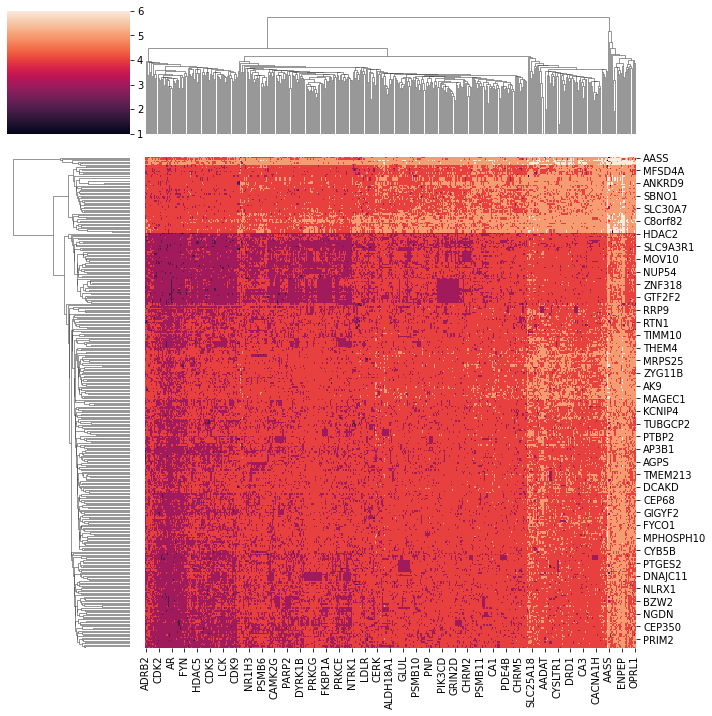

In [44]:
fig = seaborn.clustermap(distFrame, vmax=6)
plt.tight_layout()

In [45]:
#fig.savefig('DrugDisDistDebiased.png')

In [46]:
distanceGrid = {}
for k in dTars:
    distanceGrid[k] = {}
    for m in dTars:
        if networkx.has_path(net2, k, m):
            distanceGrid[k][m] = len(networkx.shortest_path(net2, k, m))
        else:
            distanceGrid[k][m] = 10

distFrame = pandas.DataFrame(distanceGrid)
print(distFrame.shape)
distFrame.head()

(458, 458)


,VCP,ALK,GRM8,CDK3,GLRA1,SLC25A18,VKORC1L1,GLS,MC4R,TNKS,...,MAOB,AKT3,HDAC9,MAP2K1,TAT,RXRB,EIF2AK4,HDAC6,PRKCD,FLT4
VCP,1,3,4,3,4,4,4,4,4,3,...,4,3,3,2,4,2,3,2,3,3
ALK,3,1,4,3,3,4,5,4,4,4,...,4,3,4,3,4,4,3,3,3,3
GRM8,4,4,1,4,5,5,5,4,4,4,...,5,4,4,4,4,4,4,4,4,4
CDK3,3,3,4,1,4,4,4,4,4,4,...,4,3,3,3,4,3,3,3,3,3
GLRA1,4,3,5,4,1,5,5,4,4,4,...,5,4,4,4,5,4,4,3,4,4


C:\Users\rahul\AppData\Roaming\Python\Python38\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


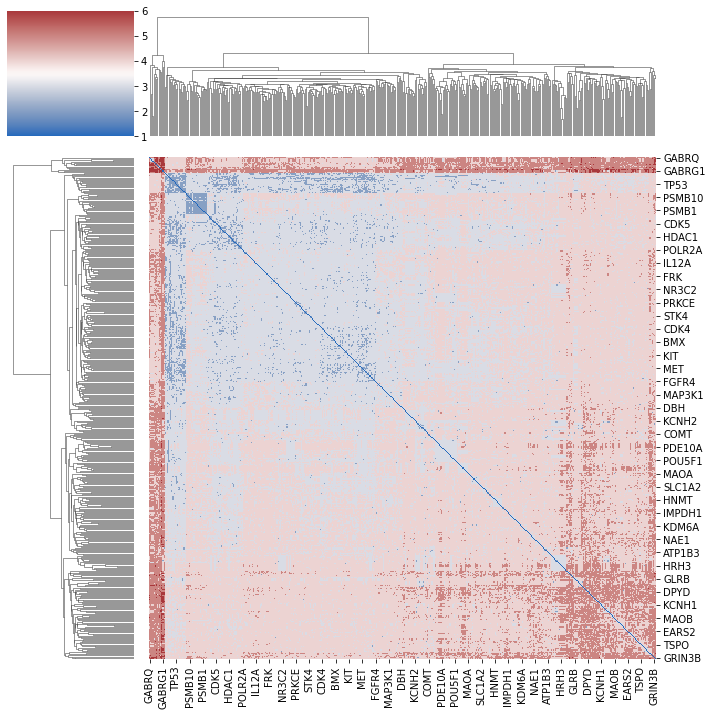

In [47]:
fig = seaborn.clustermap(distFrame, cmap='vlag')
plt.tight_layout()

In [48]:
#fig.savefig('tar_to_tar.png')

In [49]:
#General distance metric bootstrap
print(len(net2.nodes))

17970


In [50]:
dist = [0, 1, 2, 3, 4, 1, 1, 2, 4, 2]
print(random.choice(dist))

dist = []
opt = list(net2.nodes)
while len(dist) < 10**4:
    a = random.choice(opt)
    b = random.choice(opt)
    if networkx.has_path(net2, a, b):
        dist.append(len(networkx.shortest_path(net2, a, b)))
    #break
print(len(dist))

0
10000


C:\Users\rahul\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


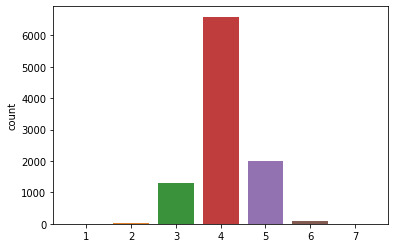

In [51]:
fig = seaborn.countplot(dist)
fig.plot()
plt.show()

In [52]:
plt.show()

209764 [1, 3, 4, 3, 4]


C:\Users\rahul\AppData\Roaming\Python\Python38\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: ylabel='count'>

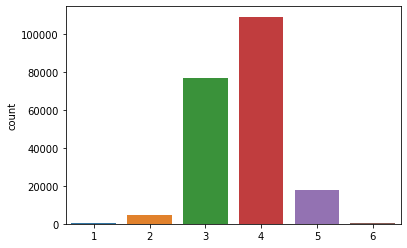

In [53]:
# Mean node separation about 4. Any 5s or 6s are strong drug combination candidates
tarDistVals = list(distFrame.values.flatten())
print(len(tarDistVals), tarDistVals[:5])
seaborn.countplot(tarDistVals)

In [54]:
possTar = list(distFrame.columns)
subTar = []
avgSumm = distFrame.mean()
subSumm = avgSumm[avgSumm >= 4]
print(len(avgSumm), len(subSumm))

subFrame = distFrame[list(subSumm.index)]
subFrame = subFrame[subFrame.index.isin(list(subSumm.index))]
print(subFrame.shape)

458 95
(95, 95)


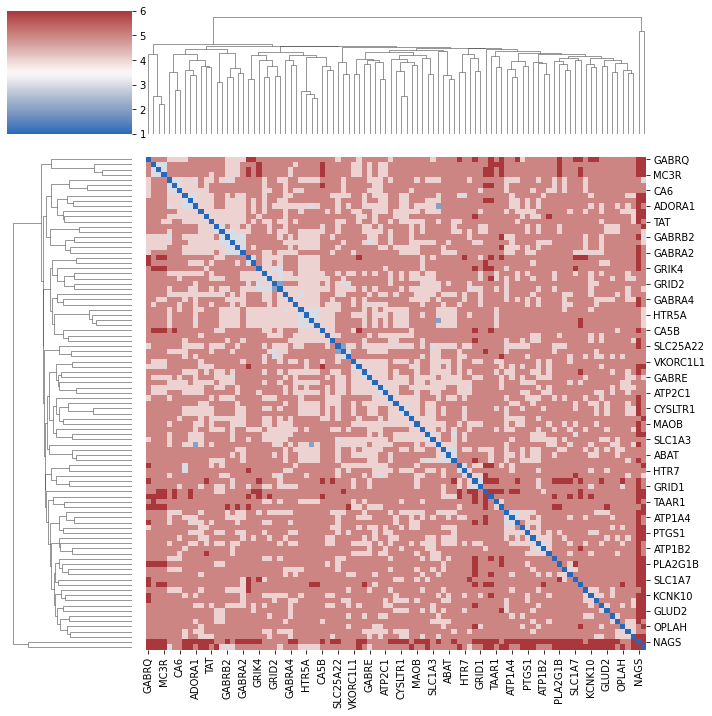

In [55]:
fig = seaborn.clustermap(subFrame, cmap='vlag')
plt.tight_layout()

In [56]:
#fig.savefig('Optimal_Combo.png')

In [57]:
possComb = list(subFrame.index)

distanceGrid = {}
for k in possComb:
    distanceGrid[k] = {}
    for m in nCmod:
        if networkx.has_path(net2, k, m):
            distanceGrid[k][m] = len(networkx.shortest_path(net2, k, m))
        else:
            distanceGrid[k][m] = 10

distFrame = pandas.DataFrame(distanceGrid)
print(distFrame.shape)
distFrame.head()

(349, 95)


,GRM8,SLC25A18,VKORC1L1,FXYD2,NAGS,MRGPRX1,CA4,CA5A,GABRQ,GRIK4,...,CA6,CTSS,KCNK18,CA13,GLUD2,GPT,AKR1B1,EARS2,MAOB,TAT
TBCA,4,5,4,4,6,4,4,4,4,5,...,4,4,4,4,4,4,4,4,4,4
GPX1,5,4,5,5,5,4,4,4,5,5,...,4,4,5,5,5,4,4,4,5,4
GLA,5,5,5,4,6,5,5,4,5,5,...,5,4,4,4,4,5,5,4,5,4
DPH5,6,6,6,6,7,5,5,5,6,6,...,6,6,5,5,6,5,6,6,6,6
SIGMAR1,5,5,4,4,6,5,5,5,5,5,...,4,4,5,4,5,5,5,5,4,5


C:\Users\rahul\AppData\Roaming\Python\Python38\site-packages\seaborn\matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


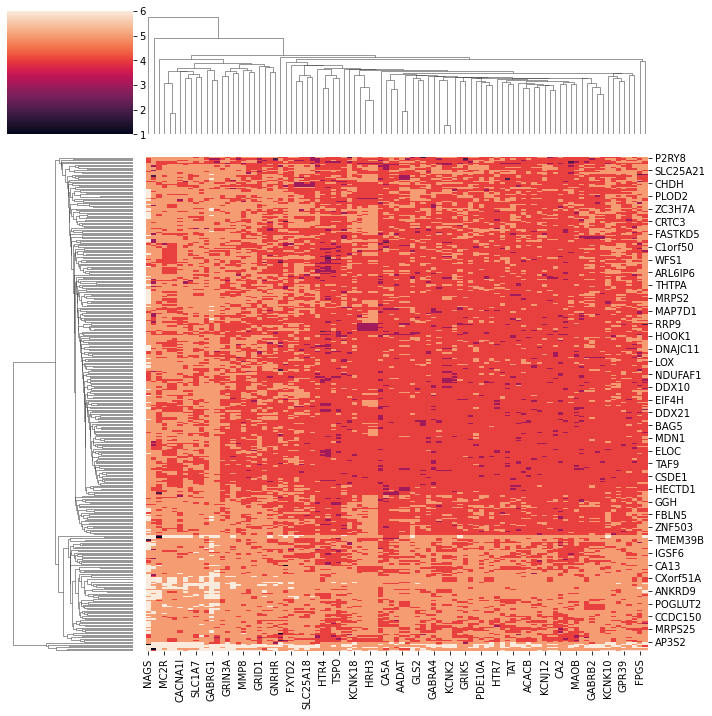

In [58]:
fig = seaborn.clustermap(distFrame, vmax=6)
plt.tight_layout()

In [59]:
#fig.savefig('ComboCand_ModuleDist.png')

# Diffusion Analysis

Treating each drug target as a seed gene, what happens if we build a diffusion module for each?

In [60]:
#Run for one target
drugAdj = networkx.to_pandas_adjacency(net2)
print(drugAdj.shape)
del(drugAdj)
#covAdj.head()

(17970, 17970)


In [61]:
#Run for multiple targets per drug
comp2 = compounds.set_index('Unnamed: 0')
print(comp2.shape)
for d in compounds.index:
    comp = list(compounds['target'][d].split('|'))
    name = compounds['pert_iname'][d]
    #print(name, comp)
comp2.head()

(448, 12)


,Pearson,pval,Std,pert_id,pert_iname,clinical_phase,moa,target,disease_area,indication,treatment,trial
Unnamed: 0,,,,,,,,,,,,
CALIBR004_A549_24H_X1_D1:B06,-0.643398,2.286969e-15,0.844560,RFM-001-779-8,NVP-BEZ235,Phase 3,mTOR inhibitor|PI3K inhibitor,ATR|MTOR|PIK3CA|PIK3CD|PIK3CG,-666,-666,CALIBR004_A549_24H_D1:B06,CALIBR004_A549_24H_X1_D1:B06
CALIBR007_A549_24H_X1_D1:I08,-0.613003,9.931355e-14,1.485403,RFM-001-664-8,camptothecin,Phase 3,topoisomerase inhibitor,TOP1,-666,-666,CALIBR007_A549_24H_D1:I08,CALIBR007_A549_24H_X1_D1:I08
CALIBR002_A549_24H_X1_D1:B15,-0.607114,1.969140e-13,0.888832,RFM-003-055-7,AP26113,Phase 2,ALK tyrosine kinase receptor inhibitor,ALK|EGFR,-666,-666,CALIBR002_A549_24H_D1:B15,CALIBR002_A549_24H_X1_D1:B15
COVID002_A549_24H_X3.A2_D1:P15,-0.606989,1.997824e-13,1.034591,BRD-K13167095,AR-42,Phase 1,HDAC inhibitor,HDAC1,-666,-666,COVID002_A549_24H_D1:P15,COVID002_A549_24H_X3.A2_D1:P15
CALIBR065_A549_24H_X1_D1:P16,-0.583119,2.783339e-12,1.056087,RFM-008-849-3,LY3023414,Phase 2,mTOR inhibitor|PI3K inhibitor,MTOR,-666,-666,CALIBR065_A549_24H_D1:P16,CALIBR065_A549_24H_X1_D1:P16


In [62]:
#Run for all targets of interest - Very time intensive step!!
assay = {}
for d in list(compounds.index):
    comp = list(compounds['target'][d].split('|'))
    if '-666' in comp:
        comp.remove('-666')
    if len(comp) > 0 and sum([k[1] for k in net.degree(comp)]) > 0:
        name = compounds['pert_iname'][d]
        print(d, name, comp)
        drugMod = avgSeedDegChooser(net, comp, set(net.nodes) - set(comp), stratify=False)#, diffuseBase)
        covidSub = drugMod[drugMod.index.isin(nCmod)]
        covidSub.head()
        del(drugMod)
        assay[name] = covidSub

0 NVP-BEZ235 ['ATR', 'MTOR', 'PIK3CA', 'PIK3CD', 'PIK3CG']
Average Overall Degree: 36.04105702364395
Average Seed Degree: 104.0


<ipython-input-14-c602dc0ef44d>:15: RuntimeWarning: divide by zero encountered in log
  quo = np.log(diffBase/(fr_diffBase + 0.000000000000001))


1 camptothecin ['TOP1']
Average Overall Degree: 36.04105702364395
Average Seed Degree: 95.0
2 AP26113 ['ALK', 'EGFR']
Average Overall Degree: 36.04105702364395
Average Seed Degree: 341.0
3 AR-42 ['HDAC1']
Average Overall Degree: 36.04105702364395
Average Seed Degree: 505.0
4 LY3023414 ['MTOR']
Average Overall Degree: 36.04105702364395
Average Seed Degree: 196.0
5 SB-939 ['HDAC1', 'HDAC10', 'HDAC2', 'HDAC3', 'HDAC4', 'HDAC5', 'HDAC6', 'HDAC9']
Average Overall Degree: 36.04105702364395
Average Seed Degree: 207.125
6 PCI-24781 ['HDAC1', 'HDAC2', 'HDAC3', 'HDAC6']
Average Overall Degree: 36.04105702364395
Average Seed Degree: 323.5
7 valrubicin ['TOP2A']
Average Overall Degree: 36.04105702364395
Average Seed Degree: 117.0
8 panobinostat ['HDAC1', 'HDAC2', 'HDAC3', 'HDAC4', 'HDAC6', 'HDAC7', 'HDAC8', 'HDAC9']
Average Overall Degree: 36.04105702364395
Average Seed Degree: 207.25
10 GDC-0349 ['PIK3CA']
Average Overall Degree: 36.04105702364395
Average Seed Degree: 100.0
11 ON123300 ['CDK4', '

KeyboardInterrupt: 

In [63]:
frame = pandas.DataFrame(assay)
print(frame.shape)
frame.head()

(349, 16)


,NVP-BEZ235,camptothecin,AP26113,AR-42,LY3023414,SB-939,PCI-24781,valrubicin,panobinostat,GDC-0349,ON123300,amsacrine,mitoxantrone,pirarubicin,SB-2343,cetilistat
AAR2,-0.977590,0.289574,-1.248752,-1.098686,-0.344487,-1.019596,-0.955678,-0.865658,-1.085105,-1.268247,-0.839588,-0.989797,-0.865658,-0.865658,-1.025276,-1.466460
AASS,-1.676823,-1.828845,-1.399755,-1.871659,-1.579757,-1.756788,-1.733069,-1.681103,-1.798727,-1.816914,-1.779791,-1.571109,-1.681103,-1.681103,-1.704685,-1.547033
AATF,1.362808,-0.436606,-1.061292,-0.500032,-0.850755,-0.601694,-0.511856,-0.455802,-0.617410,-0.993038,-0.291189,-0.446908,-0.455802,-0.455802,-1.076244,-0.980157
ABCB7,-1.294720,-0.755891,-1.260923,-1.428348,-1.105705,-1.193505,-1.313603,-1.163777,-1.430685,-1.281204,-1.262635,-0.938366,-1.163777,-1.163777,-1.347233,-1.551502
ABCC1,-0.786016,-0.862200,-0.900824,-1.197064,-0.402230,-0.793167,-0.498600,-1.076612,-0.836388,-0.765247,-0.808202,-0.055385,-1.076612,-1.076612,-0.814486,-1.665815


In [79]:
frame = pandas.read_csv('eigenvectorDiffusionResult.csv', index_col='Unnamed: 0')

In [80]:
diffVals = frame.values.flatten()
print(len(diffVals))

127036


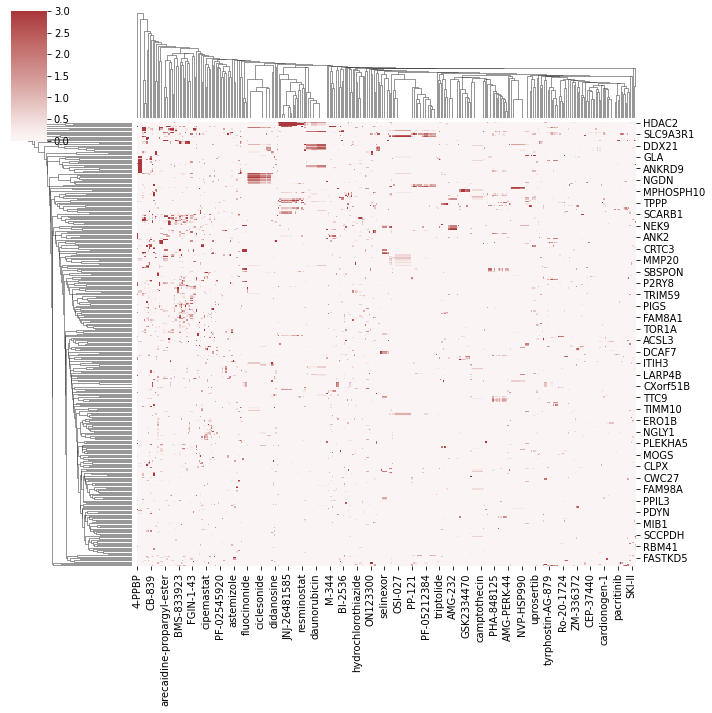

In [81]:
fig = seaborn.clustermap(frame, cmap='vlag', center = 0, vmax = 3, vmin=0)

In [69]:
frame.to_csv('eigenvectorDiffusionResult.csv')

In [82]:
#Divide dataframe into compounds scored by eigenvector centrality vs compounds scored by raw diffusion
avgNodeDegree = sum([k[1] for k in net.degree()]) / len([k[1] for k in net.degree()]) 
sub1 = []
sub2 = []
print(avgNodeDegree)
for d in list(compounds.index):
    comp = list(compounds['target'][d].split('|'))
    if '-666' in comp:
        comp.remove('-666')
    if len(comp) > 0 and sum([k[1] for k in net.degree(comp)]) > 0:
        name = compounds['pert_iname'][d]
        if sum([k[1] for k in net.degree(comp)]) / len([k[1] for k in net.degree(comp)]) > avgNodeDegree:
            sub1.append(name)
        else:
            sub2.append(name)

36.04105702364395


ValueError: The condensed distance matrix must contain only finite values.

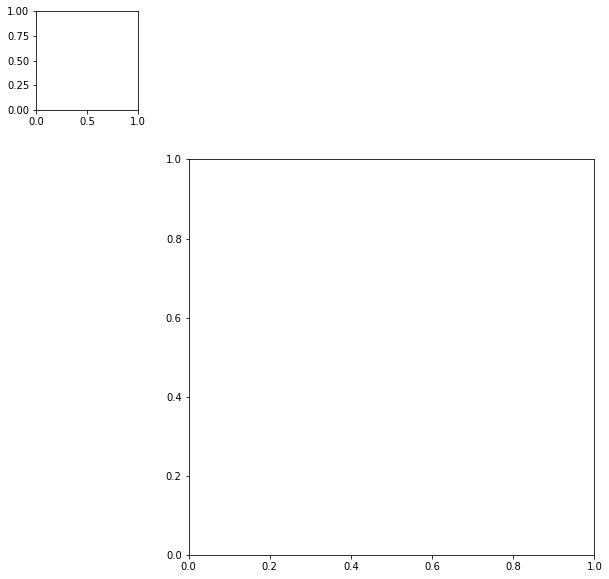

In [85]:
large = frame[sub1]
large = np.log10(large)
fig = seaborn.clustermap(large, cmap='vlag')#, vmax = 3, vmin=0)
plt.tight_layout()

In [ ]:
fig.savefig('Supp_Non_Network_Drugs2.png')

In [84]:
print([k for k in frame.index if frame['AASS'][k] > 0])
print([k for k in frame.index if frame['CA2'][k] > 0])

KeyError: 'AASS'

In [76]:
edgeList = []
possComb = list(frame.columns)
launchedCand = list(comp2[comp2['clinical_phase']=='Launched']['pert_iname'])
possComb = [k for k in possComb if k in launchedCand]
print(len(launchedCand), len(possComb), possComb[:5])
for k in range(len(possComb)):
    gene1 = possComb[k]
    for gene2 in possComb:
        diffSet1 = set(k for k in frame.index if frame[gene1][k] > 0)
        diffSet2 = set(k for k in frame.index if frame[gene2][k] > 0)
        overlap = diffSet1.intersection(diffSet2)
        bleed = diffSet1.union(diffSet2)
        edgeList.append((f, l, len(overlap), len(bleed), len(overlap)/len(bleed)))

148 5 ['valrubicin', 'panobinostat', 'amsacrine', 'mitoxantrone', 'pirarubicin']


NameError: name 'l' is not defined

In [77]:
fullFrame = pandas.DataFrame(edgeList, columns=['Seed1', 'Seed2', 'Overlap', 'Coverage', 'Jaccard'])
fullFrame.to_csv('FullInteractionStats.csv')
fullFrame['Density'] = fullFrame['Coverage']/(fullFrame['Overlap'] + 1)
#fullFrame = fullFrame[fullFrame['Density'] > 40]
#combFrame = fullFrame[fullFrame['Overlap'] == 0]
#combFrame = combFrame[combFrame['Coverage'] >= 70]
combFrame = combFrame.sort_values('Coverage', ascending=False)
#combFrame = combFrame[~combFrame['Seed1'].isin(['Ro-1138452', 'SB-221284'])]
#combFrame = combFrame[~combFrame['Seed2'].isin(['Ro-1138452', 'SB-221284'])]
#combFrame = combFrame[combFrame['Seed1'].isin(['mitoxantrone']) | combFrame['Seed2'].isin(['mitoxantrone'])]
#combFrame = combFrame[combFrame['Seed1'].isin(['homoharringtonine']) | combFrame['Seed2'].isin(['homoharringtonine'])]
print(fullFrame.shape)
fullFrame.head()

NameError: name 'combFrame' is not defined

(0, 0)


C:\Users\rahul\AppData\Roaming\Python\Python38\site-packages\seaborn\matrix.py:619: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


ValueError: The number of observations cannot be determined on an empty distance matrix.

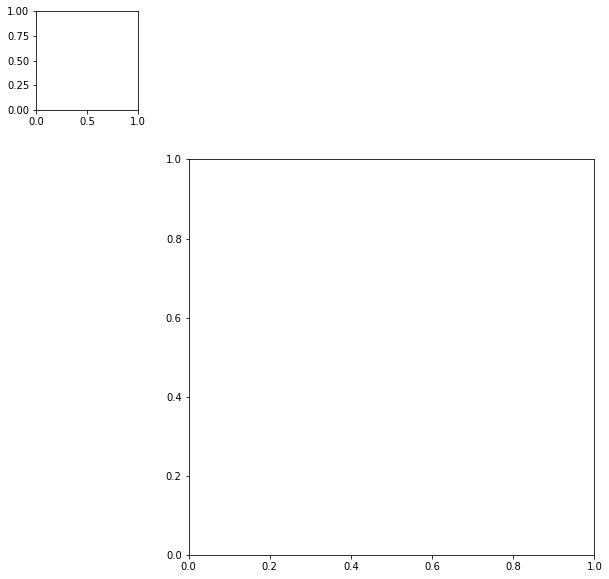

In [78]:
proxFrame = pandas.pivot_table(fullFrame, index='Seed1', columns='Seed2', values='Density', fill_value=0)
proxFrame = proxFrame.rename_axis("117 FDA Approved Compounds", axis="columns").rename_axis("117 FDA Approved Compounds", axis="index")
proxFrame.to_csv('tempHeatmapData.csv')
print(proxFrame.shape)
fig = seaborn.clustermap(proxFrame, cmap='vlag', method='ward', xticklabels=False, yticklabels=False)#, row_colors=['black'] * 117)
plt.tight_layout()
#seaborn.set(rc = {'figure.figsize':(15,20)})

In [ ]:
keyPairs = fullFrame.sort_values('Density', ascending=False)
keyPairs.head(20)

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [ ]:
#Cluster retrieval
#Row Cluster extraction
gx = fig.dendrogram_row.linkage
gx_ord = fig.dendrogram_row.reordered_ind
t = 500
gx_clus = fcluster(gx, t, criterion='distance')
print(len(gx_clus), set(gx_clus))

for n in set(gx_clus):
    print(n, sum([k == n for k in gx_clus]))

In [ ]:
proxSub = proxFrame[[k in [1, 2] for k in gx_clus]]
proxSub = proxSub.transpose()[[k in [3, ] for k in gx_clus]].transpose()
fig2 = seaborn.clustermap(proxSub, cmap='vlag', method='ward')
fig2.ax_row_dendrogram.set_visible(False)
fig2.ax_col_dendrogram.set_visible(False)
#ticagrelor and ouabain's activity potential with topoisomerase inhibitors is interesting
#Their lack of use with steroids is also notable

In [ ]:
#Cluster retrieval
#Row Cluster extraction
gx = fig.dendrogram_row.linkage
gx_ord = fig.dendrogram_row.reordered_ind
t = 400
gx_clus = fcluster(gx, t, criterion='distance')
print(len(gx_clus), set(gx_clus))

In [ ]:
# Key combos of interest
# Homoharringtonine
for n in set(gx_clus):
    print(n, sum([k == n for k in gx_clus]))
    localSubInd = list(proxFrame[[k == n for k in gx_clus]].index)
    print('homoharringtonine' in localSubInd)

In [ ]:
proxSub = proxFrame[[k in [7] for k in gx_clus]]
proxSub = proxSub.transpose()[[k in [3, 4] for k in gx_clus]].transpose()
fig2 = seaborn.clustermap(proxSub, cmap='vlag', method='ward')
fig2.ax_row_dendrogram.set_visible(False)
fig2.ax_col_dendrogram.set_visible(False)
#Homoharringtonine shows a lot of potential with pentagastrin
#Sevoflurane shows good utility with topI, steroids, and other compounds. May be anaesthetic of choice in patients with COVID-19